In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, **customer retention** has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to **predict which customers are at high risk of churn.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
# pd.set_option("max_columns", None) # show all cols
# pd.set_option('max_colwidth', None) # show full width of showing cols
# pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
# pd.options.display.max_seq_items = 200000
# pd.options.display.max_rows = 400000

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data= pd.read_csv('telecom_churn_data.csv')

In [ ]:
data.head()

In [ ]:
data.info()

### Pre-Processing Data

In [ ]:
data.shape

In [ ]:
data.describe()

#### Checking for percentage null values in each column

In [ ]:
null_perc = data.isnull().sum()/data.shape[0]*100
null_perc

### Handling Missing values

In [ ]:
#impute zero in case of missing value actually means zero
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
data[recharge_cols].describe(include= 'all')

In [ ]:
# It is also observed that the recharge date and the recharge value are missing together which means the customer didn't recharge
data.loc[data.total_rech_data_6.isnull() & data.date_of_last_rech_data_6.isnull(), 
          ["total_rech_data_6", "date_of_last_rech_data_6"]].head()

In [ ]:
data[recharge_cols].min()

In [ ]:
# create a list of recharge columns where we will impute missing values with zeroes i.e. where minimum value is not zero.
zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9'
       ]

In [ ]:
data[zero_impute]= data[zero_impute].apply(lambda x: x.fillna(0))

data[zero_impute].isnull().sum()

In [ ]:
cat_cols= ['night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9',
           'fb_user_6','fb_user_7','fb_user_8','fb_user_9']


In [ ]:
data[cat_cols].describe()

In [ ]:
data[cat_cols]= data[cat_cols].apply(lambda x: x.fillna(-1))
data.shape

In [ ]:
null_perc= data.isnull().sum()/data.shape[0]*100

In [ ]:
# Dropping columns with mor ethan 50% null values
data.drop(data.columns[null_perc>50], axis=1, inplace= True)
data.shape

In [ ]:
# Dropping columns which have same value in every row
for i in data.columns:
    if 'date' in i:
        data.drop(i, axis=1, inplace= True)
data.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'], axis=1, inplace= True)
data.shape

In [ ]:
null_perc= data.isnull().sum()/data.shape[0]*100
null_value_col_list= list(data.columns[null_perc>0])
null_value_col_list

In [ ]:
#Imputing missing values
for i in null_value_col_list:
    med= data[i].median()
    data[i].fillna(med, inplace= True)
data['onnet_mou_6'].value_counts

In [ ]:
null_perc= data.isnull().sum()/data.shape[0]*100
null_perc

### Filter High value customer

In [ ]:
# Calculate total recharge value in month of June
data['total_rech_data_amt_6']= data['total_rech_data_6']*data['av_rech_amt_data_6']
data['total_rech_6']=data['total_rech_amt_6']+data['total_rech_data_amt_6']

In [ ]:
# Calculate total recharge value in month of July
data['total_rech_data_amt_7']= data['total_rech_data_7']*data['av_rech_amt_data_7']
data['total_rech_7']=data['total_rech_amt_7']+data['total_rech_data_amt_7']

In [ ]:
# Calculate the avg recharge value of June and July
data['av_amt_data_6_7']= (data['total_rech_6']+data['total_rech_7'])/2

In [ ]:
# Calculate the 70th percentile of avg recharge value of June and July
data['av_amt_data_6_7'].describe(percentiles=[0.7])

In [ ]:
data1= data[data['av_amt_data_6_7']> 478]

In [ ]:
print('Before filtering the shape of dataframe is:',data.shape)
print('After filtering the shape of dataframe is:', data1.shape)

In [ ]:
data1.drop(['av_amt_data_6_7','total_rech_data_amt_6','total_rech_6','total_rech_data_amt_7','total_rech_7'], axis=1, inplace= True)
print('After removing the manual columns the shape of dataframe is:', data1.shape)

### Tag churners and remove attributes of the churn phase

In [ ]:
data1['churn']= data['total_ic_mou_9']+data['total_og_mou_9']+data['vol_2g_mb_9']+data['vol_3g_mb_9']
data1['churn'] = data1['churn'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
data1['churn'].describe()

In [ ]:
# change data type to category
data1.churn = data1.churn.astype("category")
# print churn ratio
print("Churn Ratio:",data1.churn.value_counts()*100/data1.shape[0])


In [ ]:
#remove attributes of the churn phase
cat_cols_9=[]
for i in data1.columns:
    if '9' in i:
        data1.drop(i, axis=1, inplace= True)
        if i in cat_cols:
            cat_cols_9.append(i)
            cat_cols.remove(i)

data1.drop('sep_vbc_3g', axis=1, inplace= True)

### Visualization of data

In [ ]:
# change columns types
id_cols= ['mobile_number']
cat_cols.append('churn')

num_cols= [col for col in list(data1.columns) if col not in cat_cols]

num_cols= [col for col in num_cols if col not in id_cols]

data1[num_cols].iloc[0]

data1[num_cols]= data1[num_cols].apply(pd.to_numeric)

data1[cat_cols] = data1[cat_cols].apply(lambda column: column.astype("category"), axis=0)

In [53]:
# create plotting functions
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def univariate(variable, stats=True):
    
    if data_type(variable) == 'numerical':
        sns.displot(variable)
        if stats == True:
            print(variable.describe())
    
    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")
        
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(x= var1, y= var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(x= var1, y= var2)

### Univariate EDA

In [ ]:
univariate(data1.arpu_6)
univariate(data1.loc_og_t2t_mou_6)
univariate(data1.std_og_mou_6)
univariate(data1.onnet_mou_6)
univariate(data1.offnet_mou_6)

As we can observe all the Variables are very <b>Skewed</b> towards the left

### Bivariate Analysis

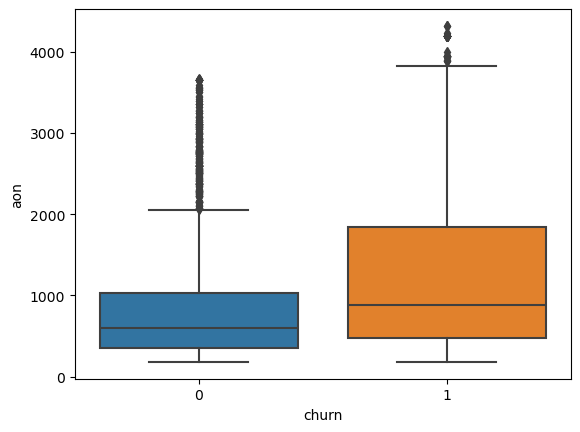

In [54]:
bivariate(data1.churn, data1.aon)

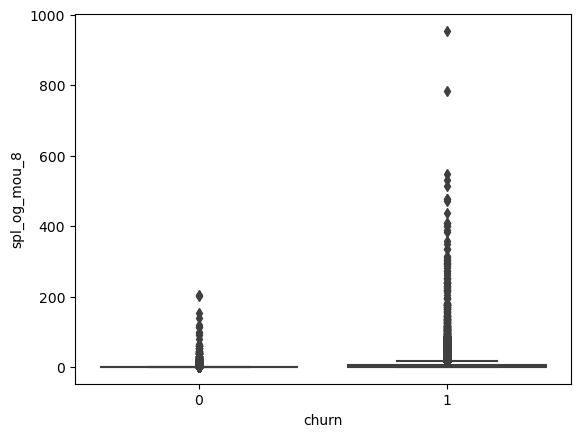

In [56]:
bivariate( data1.churn, data1.spl_og_mou_8)

In [57]:
pd.crosstab(data1.churn, data1.night_pck_user_8, normalize='columns')*100

night_pck_user_8,-1.0,0.0,1.0
churn,,,
0,14.081895,2.885725,2.639296
1,85.918105,97.114275,97.360704


In [58]:
pd.crosstab(data1.churn, data1.sachet_3g_8)

sachet_3g_8,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,25,27,29,30,38,41
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2361,48,5,8,4,2,1,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,24936,1608,397,183,106,86,43,35,28,19,15,8,11,10,6,6,2,2,3,1,3,3,2,1,1,1,2,1,1


In [59]:
#Checking for columns with zero variance and single value throughout
for i in data1.columns:
    if len(pd.value_counts(data1[i]).unique())==1:
        print(i)

mobile_number
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8


In [60]:
data1.drop(['std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'],
           axis=1, inplace= True)

In [61]:
remove_col=['std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']
for i in remove_col:
    num_cols.remove(i)

In [62]:
data1.shape

(29953, 141)

### Capping the outliers using k-sigma technique

In [63]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [64]:
# example of capping
sample_array = list(range(100))

# add outliers to the data
sample_array[0] = -9999
sample_array[99] = 9999

# cap outliers
sample_array = np.array(sample_array)
print("Array after capping outliers: \n", cap_outliers(sample_array, k=2))

Array after capping outliers: 
 [-2780     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  2877]


In [65]:
# cap outliers in the numeric columns
data1[num_cols] = data1[num_cols].apply(cap_outliers, axis=0)

In [66]:
data1.shape

(29953, 141)

### Modelling

In [67]:
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [68]:
# change churn to numeric
data1['churn'] = pd.to_numeric(data1['churn'])

### Train - Test Split

In [69]:
# divide data into train and test
X = data1.drop("churn", axis = 1)
y = data1.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)